## Movie Genre Classification

Classify a movie genre based on its plot.

<img src="https://raw.githubusercontent.com/sergiomora03/AdvancedTopicsAnalytics/main/notebooks/img/moviegenre.png"
     style="float: left; margin-right: 10px;" />



### Data

Input:
- movie plot

Output:
Probability of the movie belong to each genre


### Evaluation

- 30% Report with all the details of the solution, the analysis and the conclusions. The report cannot exceed 10 pages, must be send in PDF format and must be self-contained.
- 30% Code with the data processing and models developed that support the reported results.
- 30% Presentation of no more than 15 minutes with the main results of the project.
- 10% Model performance achieved. Metric: "AUC".

• The project must be carried out in groups of 4 people.
• Use clear and rigorous procedures.
• The delivery of the project is on March 15th, 2024, 11:59 pm, through email with Github link.
• No projects will be received after the delivery time or by any other means than the one established.




### Acknowledgements

We thank Professor Fabio Gonzalez, Ph.D. and his student John Arevalo for providing this dataset.

See https://arxiv.org/abs/1702.01992

In [ ]:
!pip install tensorflow-hub
!pip install tensorflow
!pip install openai

## Sample Submission

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer

In [2]:
dataTraining = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [3]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [4]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


In [5]:
X = dataTraining['plot']
X

3107    most is the story of a single father who takes...
900     a serial killer decides to teach the secrets o...
6724    in sweden ,  a female blackmailer with a disfi...
4704    in a friday afternoon in new york ,  the presi...
2582    in los angeles ,  the editor of a publishing h...
                              ...                        
8417    " our marriage ,  their wedding .  "  it ' s l...
1592    the wandering barbarian ,  conan ,  alongside ...
1723    like a tale spun by scheherazade ,  kismet fol...
7605    mrs .  brisby ,  a widowed mouse ,  lives in a...
215     tinker bell journey far north of never land to...
Name: plot, Length: 7895, dtype: object

In [6]:
X.shape

(7895,)

### Create y

In [7]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

In [8]:
dataTraining['genres']

3107                                       [Short, Drama]
900                               [Comedy, Crime, Horror]
6724                         [Drama, Film-Noir, Thriller]
4704                                              [Drama]
2582                            [Action, Crime, Thriller]
                              ...                        
8417                                    [Comedy, Romance]
1592                         [Action, Adventure, Fantasy]
1723       [Adventure, Musical, Fantasy, Comedy, Romance]
7605    [Animation, Adventure, Drama, Family, Fantasy,...
215               [Animation, Adventure, Family, Fantasy]
Name: genres, Length: 7895, dtype: object

In [9]:
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])
y_genres

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

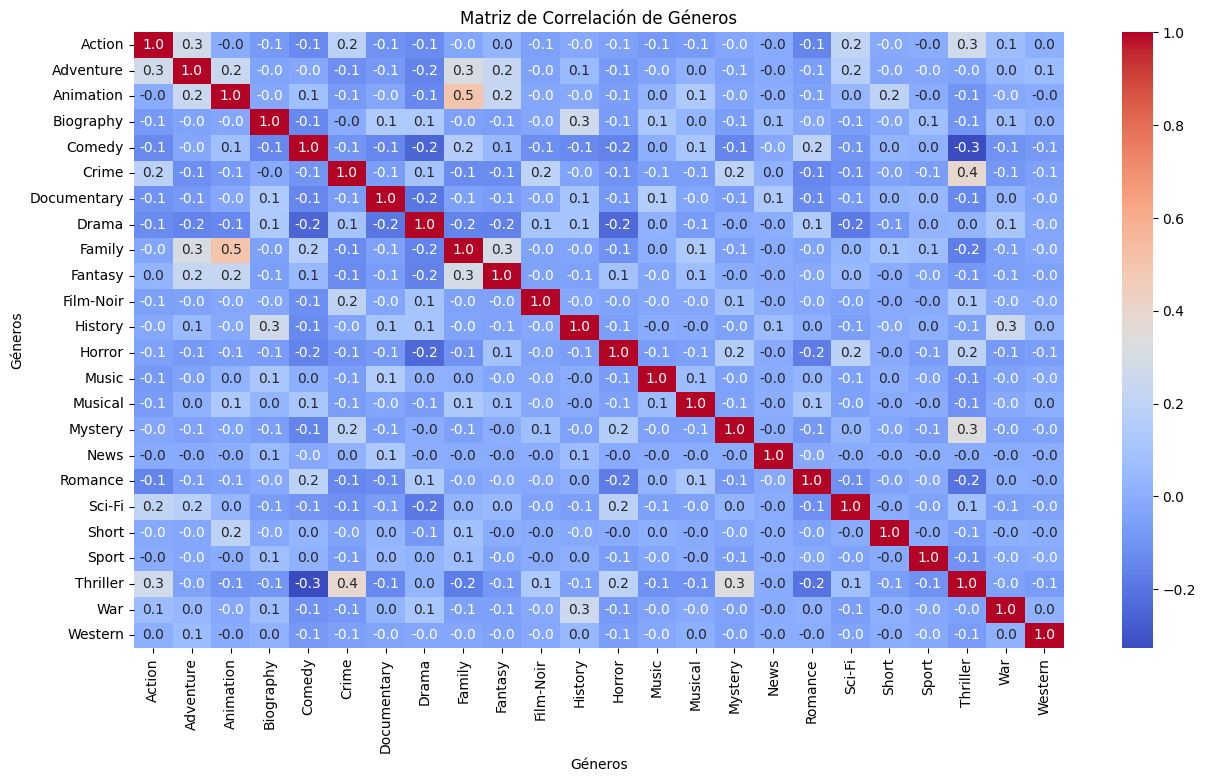

In [10]:
df_genres = pd.DataFrame(y_genres, columns=le.classes_)
correlation_matrix = df_genres.corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Matriz de Correlación de Géneros')
plt.xlabel('Géneros')
plt.ylabel('Géneros')
plt.show()

In [11]:
y_genres.shape

(7895, 24)

<ipython-input-12-a9542a42a0c6>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=le.classes_, y=genre_counts, palette='viridis')


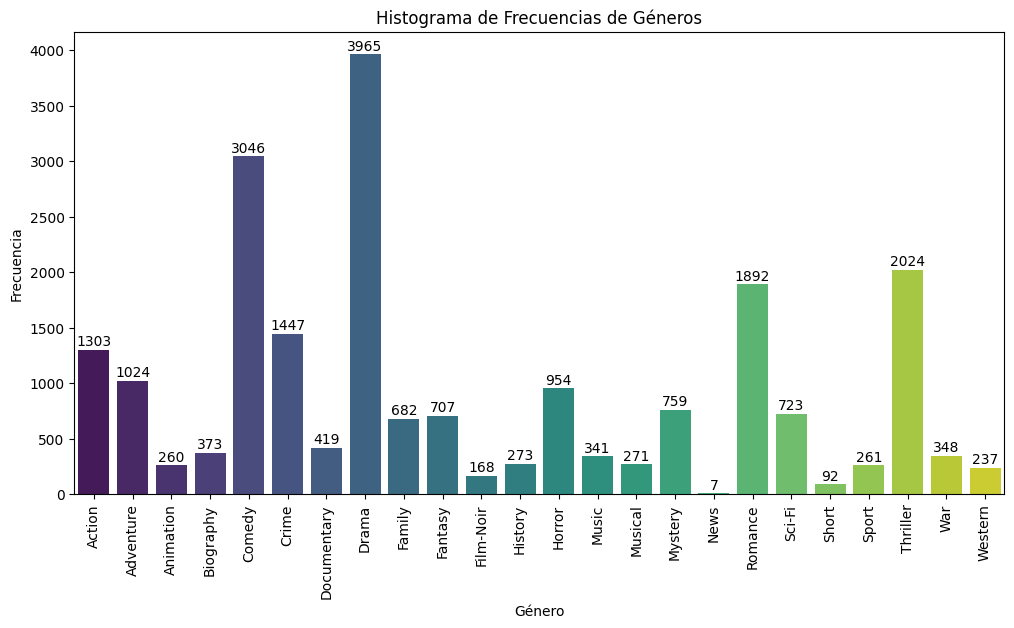

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

genre_counts = y_genres.sum(axis=0)
plt.figure(figsize=(12, 6))
sns.barplot(x=le.classes_, y=genre_counts, palette='viridis')
plt.title('Histograma de Frecuencias de Géneros')
plt.xlabel('Género')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)

# Añadir etiquetas de datos en las barras
for i, count in enumerate(genre_counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom')

plt.show()

## Processing


#### Stemming

In [13]:
# initialize stemmer
stemmer = SnowballStemmer('english')
import re

def tokenize_and_stem(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join(text.split())
    tokens = [word for word in nltk.word_tokenize(text)]
    stems = [stemmer.stem(token) for token in tokens]
    return stems

In [ ]:
vect = TfidfVectorizer(max_df=0.7,max_features=5000,stop_words='english', tokenizer=tokenize_and_stem)
X_dtm = vect.fit_transform(dataTraining['plot'])
X_dtm_title = vect.fit_transform(dataTraining['title'])
print(X_dtm.shape)

c:\Users\angui\Documents\1. Msc. Analítica de Datos\TopicosAvanzadosAnalitica\venv\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\angui\Documents\1. Msc. Analítica de Datos\TopicosAvanzadosAnalitica\venv\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 's

(7895, 5000)


### Lemmatization

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
import nltk
import string
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\angui\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\angui\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
lemmatizer = WordNetLemmatizer()
# define a function that accepts text and returns a list of lemmas
def split_into_lemmas(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    words = [word for word in nltk.word_tokenize(text)]
    return [lemmatizer.lemmatize(word) for word in words]

In [ ]:
vect = TfidfVectorizer(stop_words='english',analyzer=split_into_lemmas)
X_dtm = vect.fit_transform(dataTraining['plot'])
print(X_dtm.shape)

c:\Users\angui\Documents\1. Msc. Analítica de Datos\TopicosAvanzadosAnalitica\venv\lib\site-packages\sklearn\feature_extraction\text.py:547: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


(7895, 34553)


### Embeddings

In [14]:
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
def remove_stopwords(text):
    # Tokenizar el texto
    tokens = text.split()
    # Remover stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

def stem_tokens(tokens):
    # Stemming de las palabras
    stemmer = SnowballStemmer('english')
    tokens = [stemmer.stem(word) for word in tokens]
    return tokens

In [16]:
def processing(text):
    text = text.lower() # Convertir texto a minúsculas
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text) # Remover caracteres que no sean letras ni números
    text = re.sub(r'[^\w\s]', '', text) # Remover signos de puntuación
    tokens = remove_stopwords(text)  # Remover stop words
    tokens = stem_tokens(tokens) # Stemming de las palabras
    processed_text = ' '.join(tokens) # Unir los tokens nuevamente en texto
    return processed_text

In [29]:
dataTraining["clean"] = dataTraining["plot"].apply(processing)
dataTesting["clean"] = dataTesting["plot"].apply(processing)

In [30]:
dataTraining["clean"]

3107    stori singl father take eight year old son wor...
900     serial killer decid teach secret satisfi caree...
6724    sweden femal blackmail disfigur facial scar me...
4704    friday afternoon new york presid tredway corpo...
2582    los angel editor publish hous carol hunnicut g...
                              ...                        
8417    marriag wed lesson number one newli engag coup...
1592    wander barbarian conan alongsid goofi rogu pal...
1723    like tale spun scheherazad kismet follow remar...
7605    mrs brisbi widow mous live cinder block childr...
215     tinker bell journey far north never land patch...
Name: clean, Length: 7895, dtype: object

In [23]:
dataTraining["clean"].isnull().sum() # verifico si existen nulos

0

#### Tensorflow

In [19]:
import tensorflow as tf
import tensorflow_hub as hub

In [25]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder/4'
use_embed = hub.load(module_url)

In [31]:
train_embe_plot = use_embed(dataTraining['plot'])
test_embe_plot = use_embed(dataTesting['plot'])

In [32]:
train_embe_clean = use_embed(dataTraining['clean'])
test_embe_clean = use_embed(dataTesting['clean'])

### Análisis de sentimiento

In [33]:
from textblob import TextBlob
dataTraining['sentimiento'] = dataTraining['plot'].apply(lambda texto: TextBlob(texto).sentiment.polarity)

Stemming y Lemmatization

In [ ]:
from scipy.sparse import hstack
text_data = dataTraining['plot']

X_years = np.array(dataTraining['year']).reshape(-1, 1)
X_rating = np.array(dataTraining['rating']).reshape(-1, 1)
X_sentimiento = np.array(dataTraining['sentimiento']).reshape(-1, 1)
X_combined = hstack([X_dtm, X_years, X_sentimiento,X_rating])

Embeddings

In [37]:
X_combined = np.concatenate([train_embe_plot, dataTraining[['year', 'rating', 'sentimiento']].values],axis=1)
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

### X_dtm

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

Stemming

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier # Binary Relevance
# We will use sk-learn’s OneVsRestClassifier class to solve this problem as a Binary Relevance or one-vs-all problem:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
roc_auc_score(y_test, y_pred, average='macro')
# y_pred[1]

0.5467509587163256

In [ ]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=300, max_depth=20, random_state=42))
clf.fit(X_train, y_train)
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test, y_pred_genres, average='macro')

0.8411421152423347

In [ ]:
import xgboost as xgb
model = xgb.XGBClassifier(objective='binary:logistic')
model.fit(X_train, y_train)
y_pred_genres = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred_genres, average='macro')

0.830474553714252

Lemmatization

In [ ]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=300, max_depth=20, random_state=42))
clf.fit(X_train, y_train)
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test, y_pred_genres, average='macro')

0.8271807170430021

### X_combined

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_genres, test_size=0.33, random_state=42)

#### Con Embeddings

RandomForestClassifier

In [41]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=150, max_depth=15, random_state=42))
clf.fit(X_train, y_train)
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test, y_pred_genres, average='macro')

0.8705440983319163

XGBoost

In [55]:
import xgboost as xgb
model = xgb.XGBClassifier(objective='binary:logistic')
model.fit(X_train, y_train)
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test, y_pred_genres, average='macro')

0.8979002572687472

In [43]:
from xgboost import XGBClassifier
clf = OneVsRestClassifier(XGBClassifier())
clf.fit(X_train, y_train)
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test, y_pred_genres, average='macro')

0.9005939142969565

In [44]:
from xgboost import XGBClassifier
clf = OneVsRestClassifier(XGBClassifier(n_jobs=-1, n_estimators=100,learning_rate=0.3, max_depth=5, random_state=42))
clf.fit(X_train, y_train)
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test, y_pred_genres, average='macro')

0.8979002572687472

GradientBoostingClassifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier

gb_clf = GradientBoostingClassifier()
ovr_gb_clf = OneVsRestClassifier(gb_clf)
ovr_gb_clf.fit(X_train, y_train)
y_pred_genres = ovr_gb_clf.predict_proba(X_test)
roc_auc_score(y_test, y_pred_genres, average='macro')

Red neuronal

In [74]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics

# Limpiar la sesión de TensorFlow
tf.keras.backend.clear_session()

In [75]:
# Definir el número de clases
num_classes = y_train.shape[1]
num_classes

24

In [76]:
# Crear el modelo de red neuronal
model = Sequential()

# Agregar capas al modelo
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  # Usar 'softmax' para problemas de clasificación multiclase

# Compilar el modelo
metric = [metrics.AUC(from_logits=True, multi_label=True)]
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=metric)

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Predecir las probabilidades de las clases en el conjunto de prueba
y_pred_prob = model.predict(X_test)
# Calcular el AUC
auc = roc_auc_score(y_test, y_pred_prob, average='macro')
print(f'AUC: {auc}')

Epoch 1/10
166/166 [==============================] - 4s 16ms/step - loss: 518.1199 - auc: 0.4990 - val_loss: 1246.4952 - val_auc: 0.5000
Epoch 2/10
166/166 [==============================] - 2s 12ms/step - loss: 8272.3428 - auc: 0.4993 - val_loss: 14804.9014 - val_auc: 0.5000
Epoch 3/10
166/166 [==============================] - 3s 18ms/step - loss: 37766.8242 - auc: 0.4991 - val_loss: 52035.2461 - val_auc: 0.5000
Epoch 4/10
166/166 [==============================] - 1s 6ms/step - loss: 91258.2188 - auc: 0.5000 - val_loss: 115930.2812 - val_auc: 0.5000
Epoch 5/10
166/166 [==============================] - 1s 5ms/step - loss: 155042.6406 - auc: 0.5007 - val_loss: 195696.1406 - val_auc: 0.5000
Epoch 6/10
166/166 [==============================] - 1s 5ms/step - loss: 231656.8438 - auc: 0.4989 - val_loss: 284202.0312 - val_auc: 0.5000
Epoch 7/10
166/166 [==============================] - 1s 5ms/step - loss: 322383.3750 - auc: 0.5004 - val_loss: 392673.6562 - val_auc: 0.5000
Epoch 8/10
166

#### Con stemming y lemmatization

RandomForestClassifier

In [ ]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=300, max_depth=20, random_state=42))
clf.fit(X_train, y_train)
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test, y_pred_genres, average='macro')

0.8553544771453669

In [ ]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=500, max_depth=30, random_state=42))
clf.fit(X_train, y_train)
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test, y_pred_genres, average='macro')

0.8505680739830357

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier

gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
ovr_gb_clf = OneVsRestClassifier(gb_clf)
ovr_gb_clf.fit(X_train, y_train)
y_pred_genres = ovr_gb_clf.predict_proba(X_test)
roc_auc_score(y_test, y_pred_genres, average='macro')

XGBoost

In [ ]:
import xgboost as xgb
model = xgb.XGBClassifier(objective='binary:logistic')
model.fit(X_train, y_train)

y_pred_genres = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred_genres, average='macro')

0.8546444122449984

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
import xgboost as xgb

xgb_classifier = xgb.XGBClassifier(n_jobs=-1, n_estimators=100,learning_rate=0.3, max_depth=5, random_state=42)
model = OneVsRestClassifier(xgb_classifier)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
roc_auc_score(y_test, y_pred, average='macro')

0.62942856368493

SVC

In [ ]:
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier

svm_clf = SVC()
multi_output_clf = MultiOutputClassifier(svm_clf)
multi_output_clf.fit(X_train, y_train)
y_pred = multi_output_clf.predict(X_test)
roc_auc_score(y_test, y_pred, average='macro')

0.5458130936165024